In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator as rfg
import umap
from sklearn.decomposition import PCA
from src.visualize import plot_pic50_distributions, plot_chemspace_pca_umap

/home/thabsheerjm/Documents/Projects/bioinformatics/drug_discovery/dd_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("data/raw/influenza_neuraminidase_ic50.csv")
df.head()

,standard_value,standard_units,standard_relation,canonical_smiles
0,48730.00,nM,=,CC(=O)N1C[C@H](O)C[C@@H]1C(=O)O
1,281838.29,nM,=,CC(=O)N1C[C@H](O)C[C@@H]1C(=O)O
2,1060.00,nM,=,CCOC(=O)C1=C[C@@H](OC(CC)CC)[C@H](NC(C)=O)[C@@...
3,3235.94,nM,=,CCOC(=O)C1=C[C@@H](OC(CC)CC)[C@H](NC(C)=O)[C@@...
4,48010.00,nM,=,COC(=O)[C@@H]1C[C@@H](N)CN1C(=O)[C@@H](N)CC(C)C


## Preprocessing 

In [3]:
# basic filtering
df = df[(df["standard_units"] == "nM") & (df["standard_relation"] == "=") &
        (df["standard_value"] > 0)]
# remove duplicates
df = df.sort_values("standard_value")
df = df.drop_duplicates(subset="canonical_smiles", keep="first")
print(f"Shape of data after basic cleaning: {df.shape}")

Shape of data after basic cleaning: (669, 4)


In [4]:
# Add bioactivity class using standard drug discovery cut-off
df['bioactivity_class'] = 'intermediate'
df.loc[df['standard_value']<=1000, 'bioactivity_class'] = 'active'
df.loc[df['standard_value']>=10000,'bioactivity_class'] = 'inactive'

In [5]:
# IC50 (nM) --> pIC50
df["pIC50"] = 9 - np.log10(df["standard_value"])

In [6]:
# Save the processed data
processed_out_file = "data/processed/influenza_neuraminidase_pic50.csv"
df = df[['canonical_smiles', 'pIC50', 'bioactivity_class']]
df.to_csv(processed_out_file, index=False)
print(f"Saved cleaned data: {len(df)} molecules")

Saved cleaned data: 669 molecules


## Data Exploration & Visualization

In [7]:
df.sample(5)

,canonical_smiles,pIC50,bioactivity_class
1628,N#Cc1ccc(CN(Cc2ccc(C#N)cc2)CC(O)/C=C/c2ccccc2)cc1,4.302771,inactive
1220,CCCCCCCCCO[C@@H]1C=C(C(=O)O)C[C@H](N)[C@H]1NC(...,6.676996,active
282,CC(=O)N[C@H]1[C@H]([C@H](OC(=O)NCc2cn(CCOCCOCC...,8.070581,active
116,CC(=O)Nc1c(O)cc(C(=O)O)cc1[N+](=O)[O-],-2.875100,inactive
1339,CCC(CC)O[C@@H]1C=C(C(=O)O)C[C@H](NCCCN)[C@H]1N...,6.022276,active


Figure saved as: save/Neuraminidase_pIC50_Distribution.svg


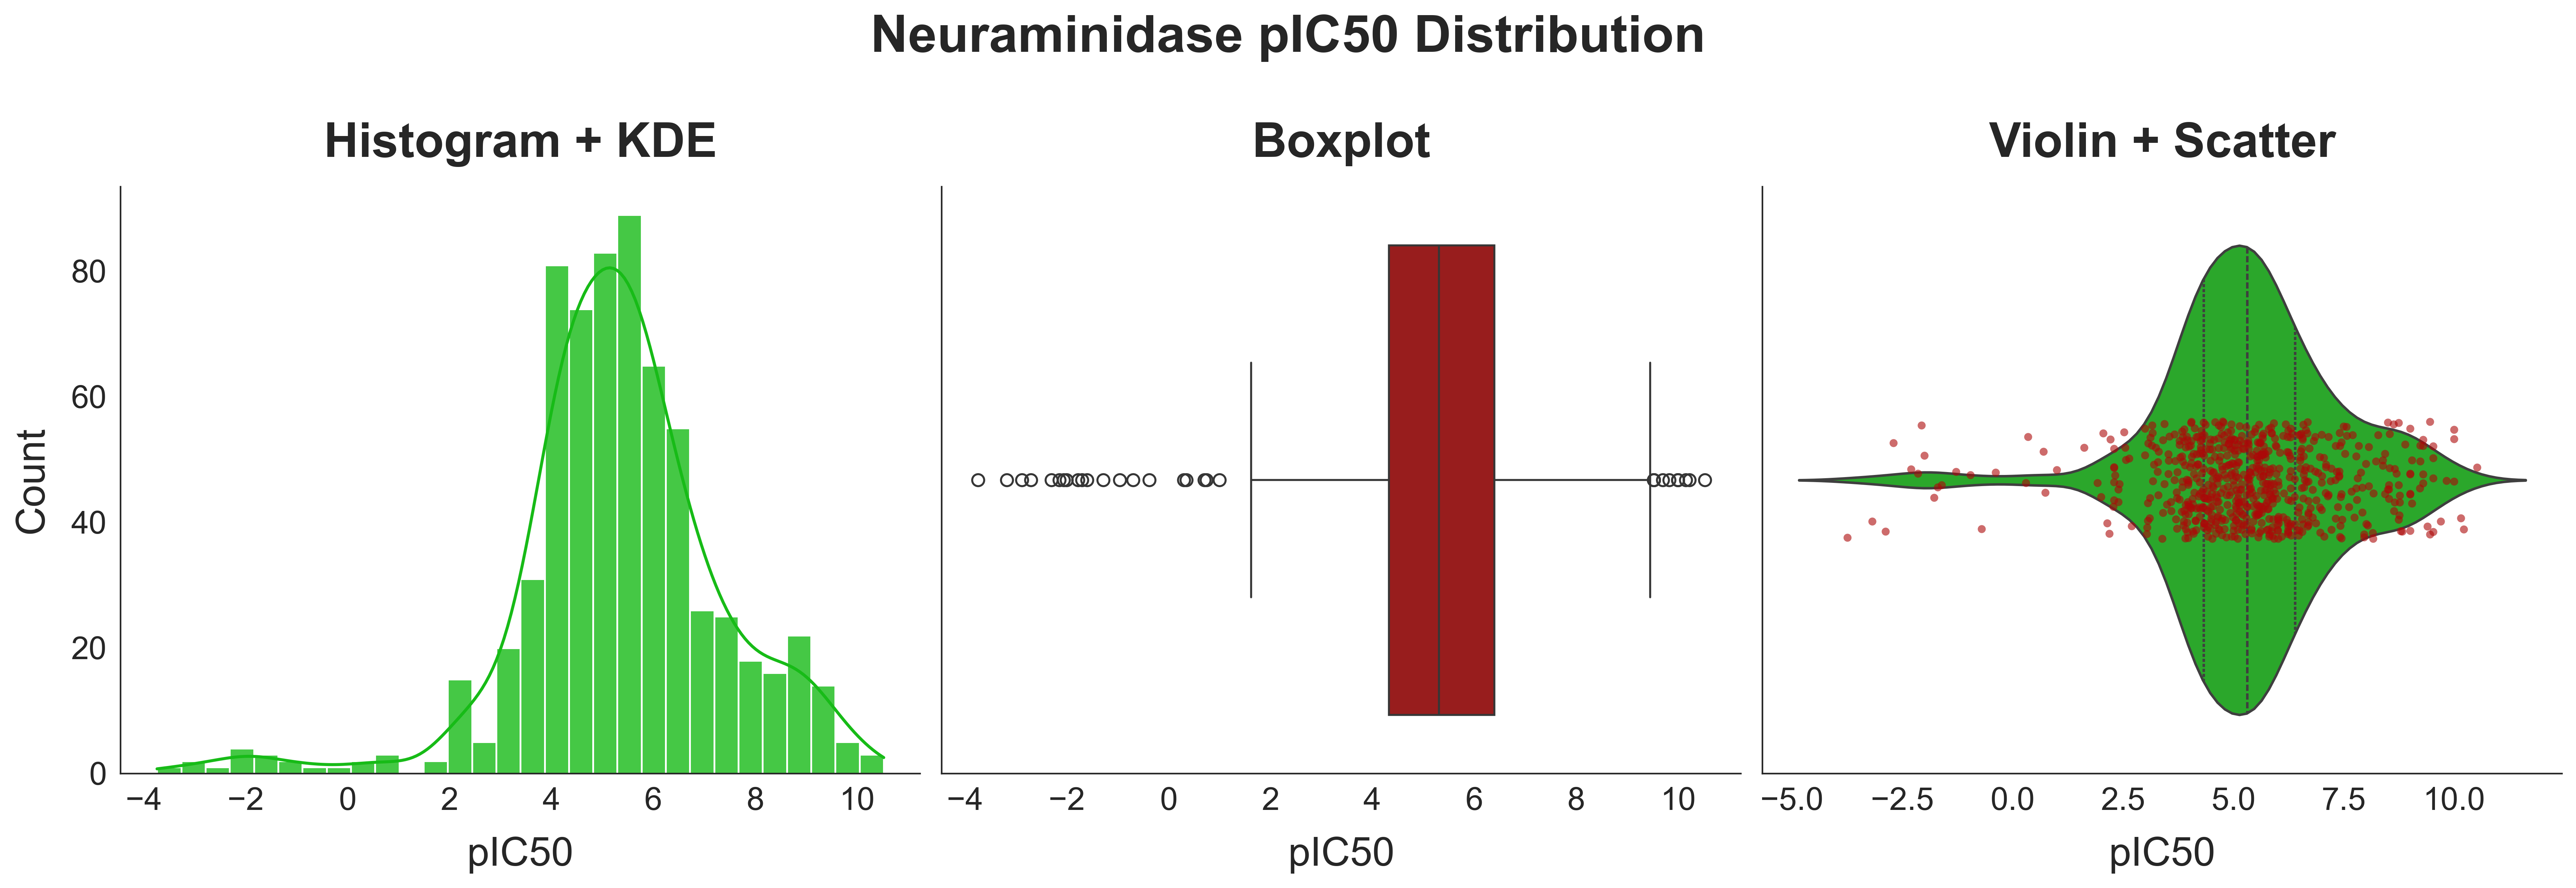

In [8]:
plot_pic50_distributions(df)

In [9]:
# convert smiles to rdkit molecule objects
df['mol'] = df['canonical_smiles'].apply(Chem.MolFromSmiles)
# Compute Morgan fingerprints
gen = rfg.GetMorganGenerator(radius=2, fpSize=1024)
fps = [gen.GetFingerprint(m) for m in df['mol']]
fps_array = np.array([np.array(fp) for fp in fps])
print(f"Shape of fingerprint array: {fps_array.shape}")

Shape of fingerprint array: (669, 1024)


In [10]:
# PCA
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(fps_array)

#UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
umap_coords = reducer.fit_transform(fps_array)


/home/thabsheerjm/Documents/Projects/bioinformatics/drug_discovery/dd_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


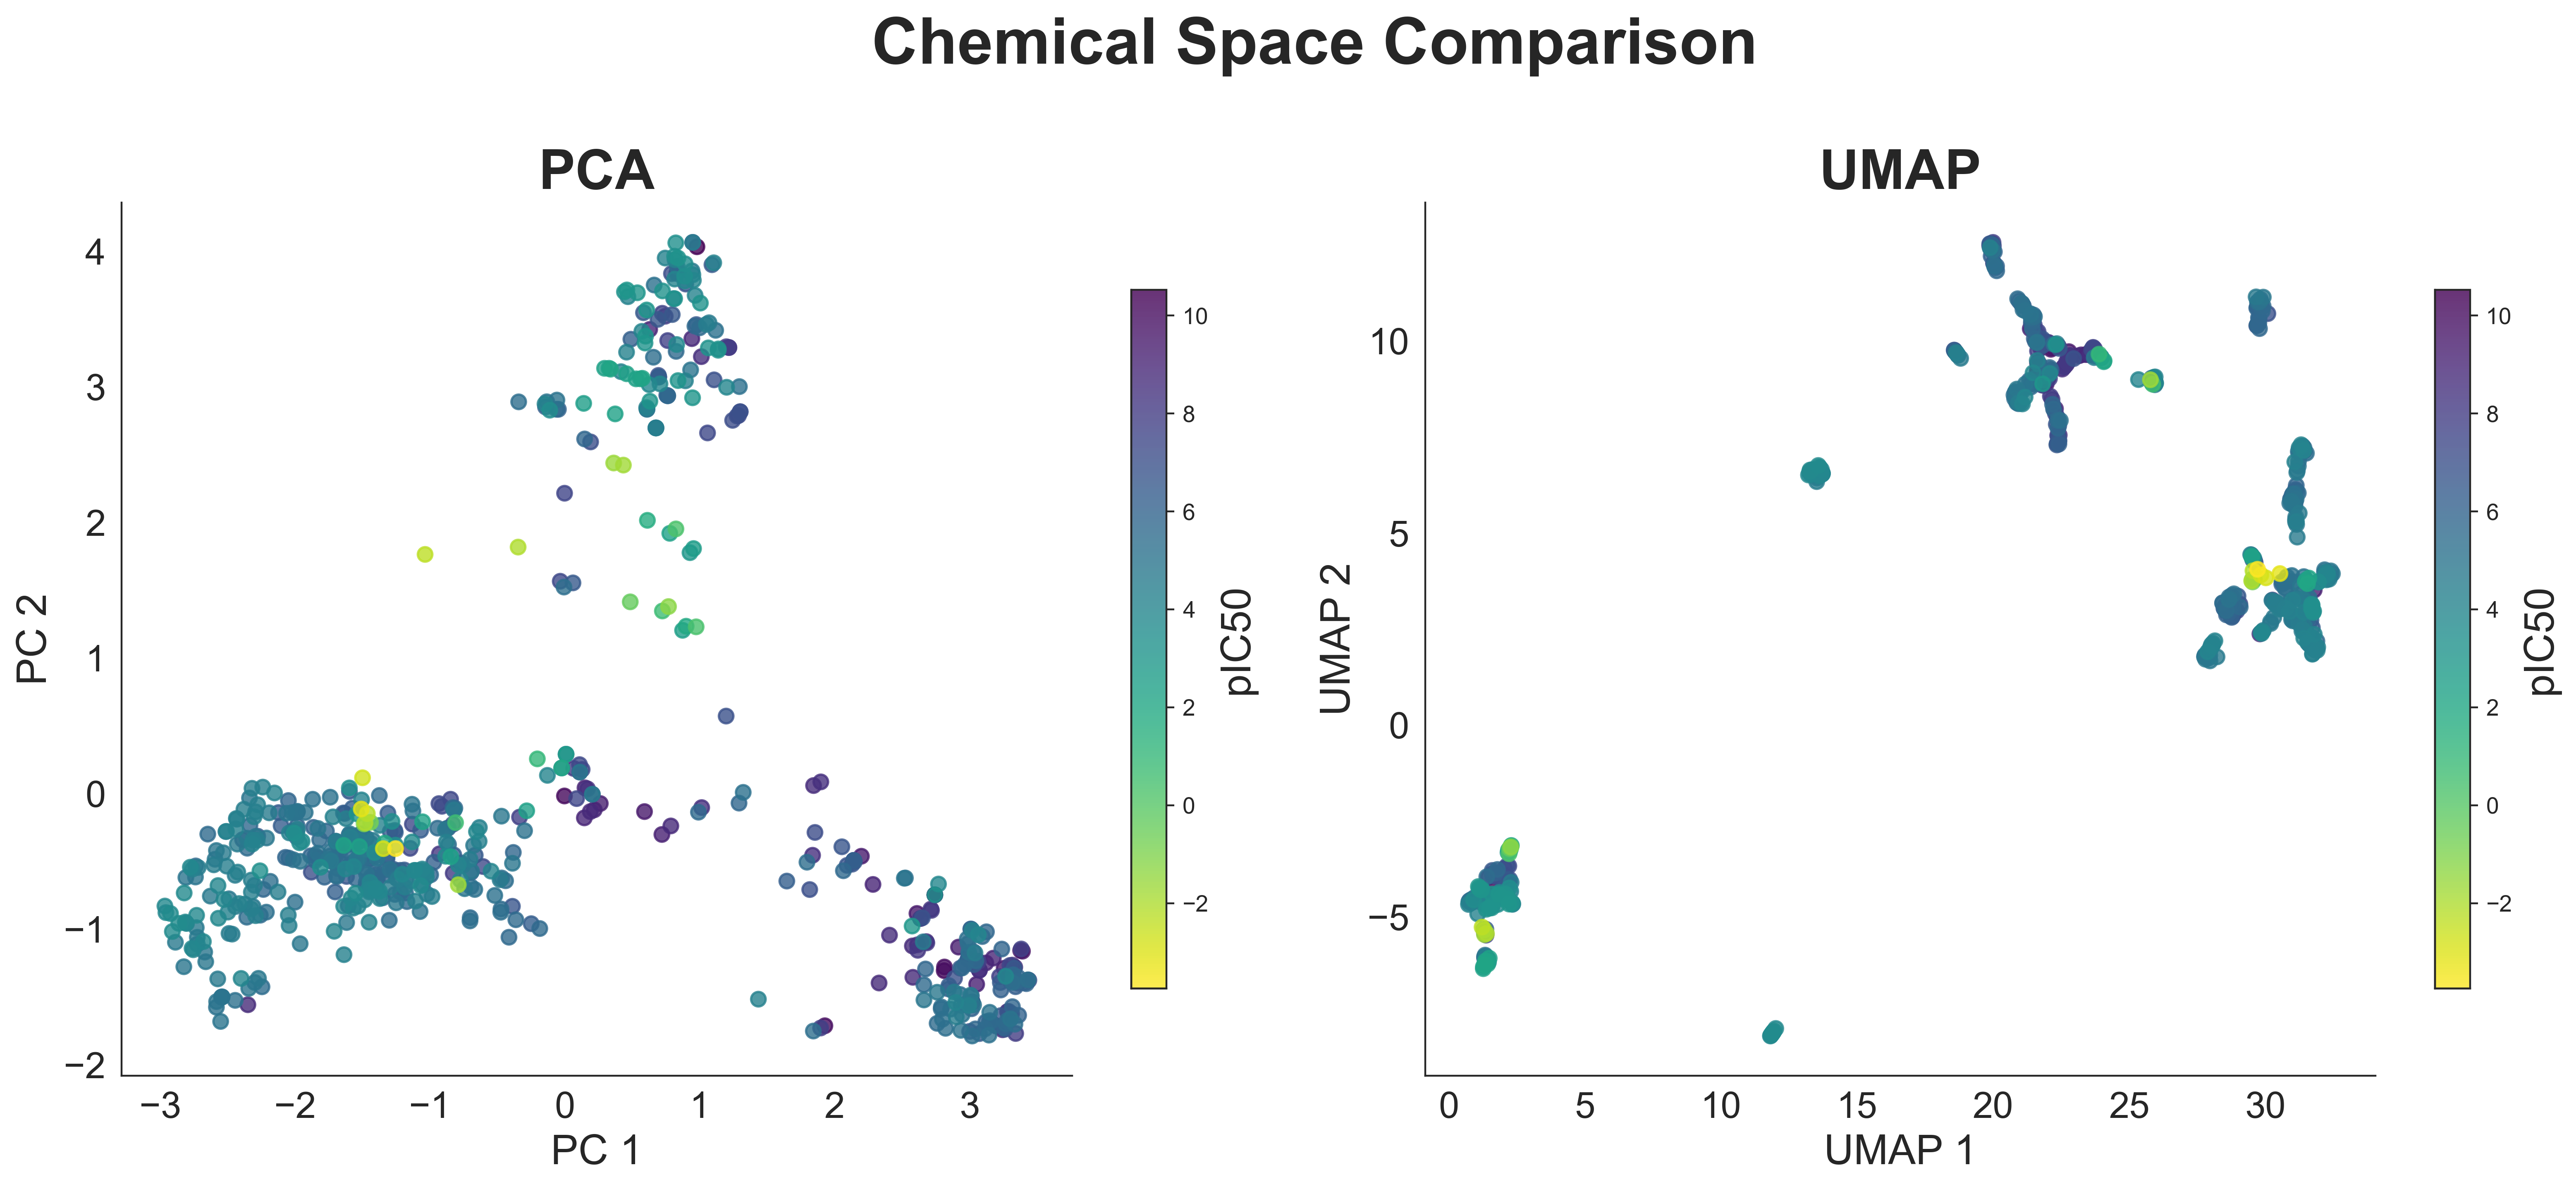

Figure saved as: save/Chemical_Space_Comparison.svg


In [11]:
plot_chemspace_pca_umap(df, pca_coords,umap_coords)